In [35]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [36]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    # files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]      
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [37]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_liver"

In [38]:
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 1/1 [00:00<00:00, 33.58it/s]


In [39]:
merged=pd.merge(quant,rate,left_on=['Peptide','Charge'],right_on=['Peptides','Charge'])
merged=merged[merged['Rsquared']>0.8].reset_index(drop=True)

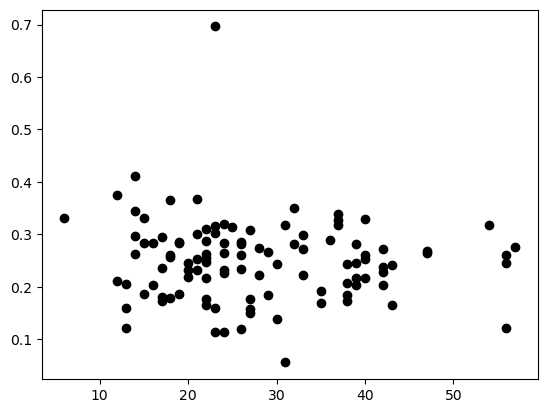

In [40]:
plt.scatter(merged.NEH,merged.RateConstants,c='k')

In [41]:
BW = [0, 0.0386, 0.0448, 0.0458, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046]
allTime = [0, 1, 2, 3, 6, 7, 9, 13, 16, 21, 24, 31]
ph=1.5574E-4

In [42]:
def get_I0_t(time,data,index):
    index_t=allTime.index(time)
    suffix="" if index_t==0 else f".{index_t}"
    total=0
    for i in range(6):
        try:total+= int(data.loc[index,f"I{i}{suffix}"])
        except: continue
    
    ria=None
    
    if total!=0: 
        try:
            ria=int(data.loc[index,f"I0{suffix}"])/total
        except: ria=None
        
    return ria


def get_I0_asmyp(data,index):
    M0=data.loc[index,'M0']/100
    bwe=0.046
    neh=data.loc[index,'Exchangeable Hydrogens']
    i0_asy=M0*((1-bwe/(1-ph))**neh)
    return i0_asy

In [43]:
def getRate_pxt_neh_div(time,pxt,neh,showplot=False): 

  bwe=0.046
  
  y=[  (1 - pxtval/ (neh* (1-ph)) )**neh for pxtval in pxt]
  x=time
  
  def objective(t, k):
    return (1 - bwe/(neh* (1-ph)) )**neh + ( 1 - (1 - bwe/(neh* (1-ph)))**neh)* np.exp(-k * t) 

  popt, _ = curve_fit(objective, x, y)

  k= popt

  if showplot:
    print(f'k = {k}')

    pyplot.figure(figsize=(9,5))
    pyplot.scatter(x, y,s=75,c='b',alpha=0.6)
    x_line = range(min(min(x),0), max(x)+3, 1)
    y_line = objective(x_line, k)
    pyplot.plot(x_line, y_line, '--', color='red')

    # Remove top and right spines
    ax = pyplot.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    pyplot.xticks(x,x)

    pyplot.savefig("fitplot.png",dpi=900, transparent=True)

    pyplot.show()
  
  return k[0]

In [44]:
def getRate_pxt(time,pxt,neh,showplot=False): 

  bwe=0.046
  
  y=[  (1 - pxtval/(1-ph))**neh for pxtval in pxt]
  x=time
  
  def objective(t, k):
    return (1 - bwe/(1-ph))**neh + ( 1 - (1 - bwe/(1-ph))**neh)* np.exp(-k * t) 

  popt, _ = curve_fit(objective, x, y)

  k= popt

  if showplot:
    print(f'k = {k}')

    pyplot.figure(figsize=(9,5))
    pyplot.scatter(x, y,s=75,c='b',alpha=0.6)
    x_line = range(min(min(x),0), max(x)+3, 1)
    y_line = objective(x_line, k)
    pyplot.plot(x_line, y_line, '--', color='red')

    # Remove top and right spines
    ax = pyplot.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    pyplot.xticks(x,x)

    pyplot.savefig("fitplot.png",dpi=900, transparent=True)

    pyplot.show()
  
  return k[0]

In [45]:
def getRate(x,y,i0_asy,M0,showplot=False): 

  def objective(t, k):
    return i0_asy + ( M0 - i0_asy)* np.exp(-k * t) 

  popt, _ = curve_fit(objective, x, y)

  k= popt

  if showplot:
    print(f'k = {k}')

    pyplot.figure(figsize=(9,5))
    pyplot.scatter(x, y,s=75,c='b',alpha=0.6)
    x_line = range(min(min(x),0), max(x)+3, 1)
    y_line = objective(x_line, k)
    pyplot.plot(x_line, y_line, '--', color='red')

    # Remove top and right spines
    ax = pyplot.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    pyplot.xticks(x,x)

    pyplot.savefig("fitplot.png",dpi=900, transparent=True)

    pyplot.show()
  
  return k[0]

In [46]:
def get_all_RIA(data,index):
    _time,_ria=[],[]
    for time in allTime:
        tempria=get_I0_t(time,data,index)
        if not tempria: continue
        _time.append(time)
        _ria.append(tempria)        
    return _time,_ria

In [47]:
def getPxt(I0_0,I0_t,neh): 
    return (1-ph)*(1-(I0_t/I0_0)**(1/neh))
    
# def getAllpxt(ria,time,neh):
#     return [getPxt(ria[0],ria[i],neh) for i in range(len(time))]

def getAllpxt(ria,time,neh,M0):
    return [getPxt(M0,ria[i],neh) for i in range(len(time))]

In [48]:
# index=0
# merged.loc[index,'M0']/100,get_all_RIA(merged,index)


In [49]:
# M0=merged.loc[index,'M0']/100
# neh=merged.loc[index,'Exchangeable Hydrogens']
# time,ria=get_all_RIA(merged,index)
# getAllpxt(ria,time,neh,M0)

In [50]:
k_pep,k_charge,k_csv,k_fit_d2ome,k_pxts,k_times,k_nehs,rates_frompxts=[],[],[],[],[],[],[],[]
for index in tqdm(range(merged.shape[0])):
    M0=merged.loc[index,'M0']/100
    time,ria=get_all_RIA(merged,index)
    i0_asy=get_I0_asmyp(merged,index)
    neh=merged.loc[index,'Exchangeable Hydrogens']
    
    
    if(len(time)<4) or 0 not in time: continue
    
    k_nehs.append(neh)
    k_times.append(time)
    k_fit_d2ome.append(getRate(time,ria,i0_asy,M0,False))
    k_csv.append(merged.loc[index,'RateConstants'])
    k_pep.append(merged.loc[index,'Peptides'])
    k_charge.append(merged.loc[index,'Charge'])
    k_pxts.append(getAllpxt(ria,time,neh,M0))
    
    
    
    rates_frompxts.append(getRate_pxt(time,k_pxts[-1],neh,showplot=False))
    
    

100%|██████████| 106/106 [00:01<00:00, 56.68it/s]


In [51]:
# plt.plot(k_csv,k_csv,c='r',ls='-.')
# plt.scatter(k_csv,rates_frompxts,c='k')
# plt.xlabel("k (d2ome)")
# plt.ylabel("k (computed)")

In [52]:
temp_res=[]

for i in tqdm(range(len(k_pxts))):
    for j in range(len(k_pxts[i])):        
        temp_res.append([k_pep[i],k_charge[i],k_nehs[i],k_csv[i],k_times[i][j],k_pxts[i][j]])
        
temp_res=pd.DataFrame(temp_res)
temp_res.columns=['Peptide','Charge','neh','rate','time','pxt']
temp_res.head()        

100%|██████████| 106/106 [00:00<00:00, 40337.16it/s]


,Peptide,Charge,neh,rate,time,pxt
0,DGAWGAFR,2,17,0.23699,0,-0.001595
1,DGAWGAFR,2,17,0.23699,1,0.003651
2,DGAWGAFR,2,17,0.23699,2,0.013243
3,DGAWGAFR,2,17,0.23699,3,0.014625
4,DGAWGAFR,2,17,0.23699,6,0.037906


In [53]:
def updated_lr(X,y):
    X=np.array(X)
    y=np.array(y)
    
    X=X.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    
    return model.coef_[0] , model.intercept_

Coefficient (slope): -0.0002332575227528977
Intercept: 0.04051242188801785


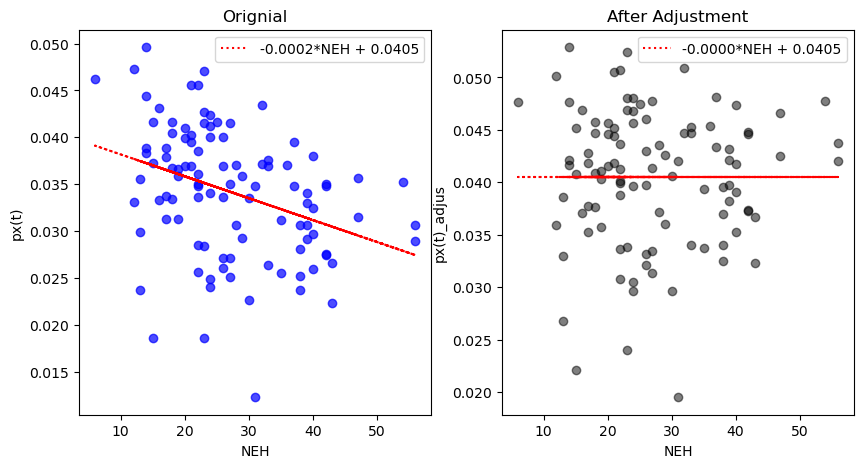

In [54]:
def linearRegerssion(X,y,verbose=False):
    X=np.array(X)
    y=np.array(y)
    
    X=X.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)
    newpxts=model.intercept_+ (y-y_pred)
    
    # newpxts=(np.array(y) - model.coef_[0]*np.array(X).flatten())
    
    # print(  model.intercept_+ (y-y_pred),
    #       (np.array(y) - model.coef_[0]*np.array(X).flatten()))
    
    # print(y-y_pred)
    
    
    

    if verbose:
        # Output
        print("Coefficient (slope):", model.coef_[0])
        print("Intercept:", model.intercept_)

        # # Plotting
        # plt.scatter(X, y, color='blue', label='Data points')
        # plt.plot(X, y_pred, color='red', label='Regression line')
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.scatter(X, y, color='blue',alpha=0.7)
        plt.plot(X, y_pred, color='red',ls=':', label=f'{model.coef_[0]:.4f}*NEH + {model.intercept_:.4f}')
        plt.xlabel("X")
        plt.ylabel("y")
        plt.title("Orignial")
        plt.legend()
        plt.xlabel("NEH")
        plt.ylabel("px(t)")
        
        _slope,_intercept=updated_lr(X,newpxts)
        plt.subplot(1,2,2)
        plt.scatter(X,newpxts,c='k',alpha=0.5)
        plt.plot(X,[model.intercept_]*len(X),c='r',ls=':',label=f'{_slope:.4f}*NEH + {_intercept:.4f}')
        plt.title("After Adjustment")
        plt.legend()
        
        plt.xlabel("NEH")
        plt.ylabel("px(t)_adjus")
        plt.show()
    
    return newpxts
    


pltdata=temp_res[temp_res.time==6]    
_=linearRegerssion(np.array(pltdata.neh),np.array(pltdata.pxt),True)

In [55]:
updatedData=pd.DataFrame()
for t in allTime: 
    pltdata=temp_res[temp_res.time==t] 
    pltdata['Adjust_pxt']=linearRegerssion(np.array(pltdata.neh),np.array(pltdata.pxt),False)
    updatedData=pd.concat([pltdata,updatedData])
updatedData.head()
    

,Peptide,Charge,neh,rate,time,pxt,Adjust_pxt
11,DGAWGAFR,2,17,0.23699,31,0.044988,0.049738
23,AQVEDAFR,2,22,0.24816,31,0.042836,0.048983
35,LTQGEVYK,2,12,0.37448,31,0.050558,0.053911
47,AVAHILGIR,2,19,0.18633,31,0.038332,0.043640
59,VLEALLPLK,2,14,0.26288,31,0.046658,0.050570


In [56]:
temp_updated=updatedData.groupby(by=['Peptide','Charge','neh','rate']).aggregate({"time":[list],"pxt":[list],"Adjust_pxt":[list]})
temp_updated=temp_updated.reset_index()
temp_updated.columns=['Peptide','Charge','neh','rate','time','pxt','adjpxt']

In [57]:
# index=0
# getRate_pxt(temp_updated.loc[index,'time'],temp_updated.loc[index,'pxt'],temp_updated.loc[index,'neh'])

In [58]:
# getRate_pxt_neh_div(temp_updated.loc[index,'time'],temp_updated.loc[index,'adjpxt'],temp_updated.loc[index,'neh'])

In [59]:
# plt.scatter(temp_updated.neh,
#             [getRate_pxt(temp_updated.loc[index,'time'],temp_updated.loc[index,'pxt'],temp_updated.loc[index,'neh']) for index in range(temp_updated.shape[0])])

Text(0.5, 1.0, 'Mean = 0.252, Median = 0.256, SD = 0.0706')

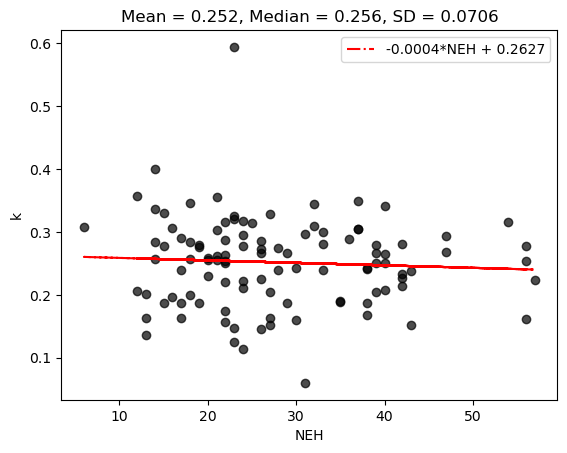

In [60]:
new_Rate_formula=[getRate_pxt_neh_div(temp_updated.loc[index,'time'],temp_updated.loc[index,'adjpxt'],temp_updated.loc[index,'neh']) for index in range(temp_updated.shape[0])]
# new_Rate_formula=[getRate_pxt_neh_div(temp_updated.loc[index,'time'],temp_updated.loc[index,'pxt'],temp_updated.loc[index,'neh']) for index in range(temp_updated.shape[0])]


_slope,_intercept=updated_lr(temp_updated.neh,new_Rate_formula)
plt.scatter(temp_updated.neh,new_Rate_formula,c='k',alpha=0.7)
plt.plot(temp_updated.neh,[_slope*i +_intercept for i in temp_updated.neh],c='r',ls="-.",
            label=f'{_slope:.4f}*NEH + {_intercept:.4f}')
plt.legend()
plt.xlabel("NEH")
plt.ylabel("k")


plt.title(f"Mean = {np.mean(new_Rate_formula):.3f}, Median = {np.median(new_Rate_formula):.3f}, SD = {np.std(new_Rate_formula):.4f}")

Text(0.5, 1.0, 'Mean = 0.250, Median = 0.253, SD = 0.0782')

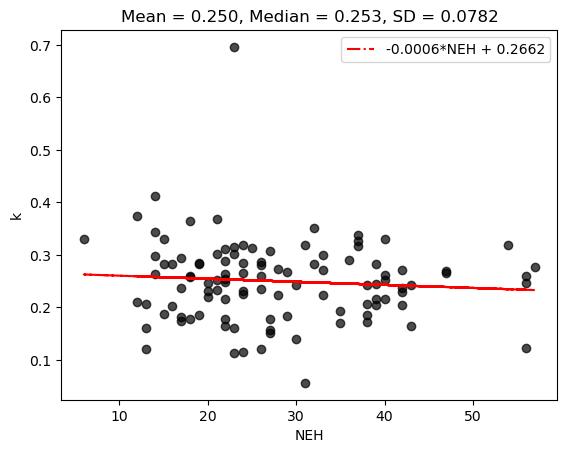

In [61]:
# plt.scatter(temp_updated.neh,temp_updated.rate)
# np.mean(temp_updated.rate),np.median(temp_updated.rate),np.std(temp_updated.rate),updated_lr(temp_updated.neh,temp_updated.rate)

_slope,_intercept=updated_lr(temp_updated.neh,temp_updated.rate)
plt.scatter(temp_updated.neh,temp_updated.rate,c='k',alpha=0.7)
plt.plot(temp_updated.neh,[_slope*i +_intercept for i in temp_updated.neh],c='r',ls="-.",
            label=f'{_slope:.4f}*NEH + {_intercept:.4f}')
plt.legend()
plt.xlabel("NEH")
plt.ylabel("k")


plt.title(f"Mean = {np.mean(temp_updated.rate):.3f}, Median = {np.median(temp_updated.rate):.3f}, SD = {np.std(temp_updated.rate):.4f}")

In [62]:
np.median(temp_updated.rate)*0.25

0.06324250000000001

In [63]:
temp_updated.rate[(temp_updated.rate >= np.median(temp_updated.rate) - np.median(temp_updated.rate)*0.25) &
                  ((temp_updated.rate <= np.median(temp_updated.rate) + np.median(temp_updated.rate)*0.25))].shape[0]/temp_updated.shape[0]

0.6226415094339622